# matplotlib 설정

In [1]:
import matplotlib.pyplot as plt
import platform


if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
elif platform.system() == "Darwin":
    plt.rcParams["font.family"] = "Apple SD Gothic Neo"

plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "regular"
plt.rcParams["axes.unicode_minus"] = False

# 머신러닝 모델 학습 및 예측

모델 학습 중...
Fitting 5 folds for each of 128 candidates, totalling 640 fits


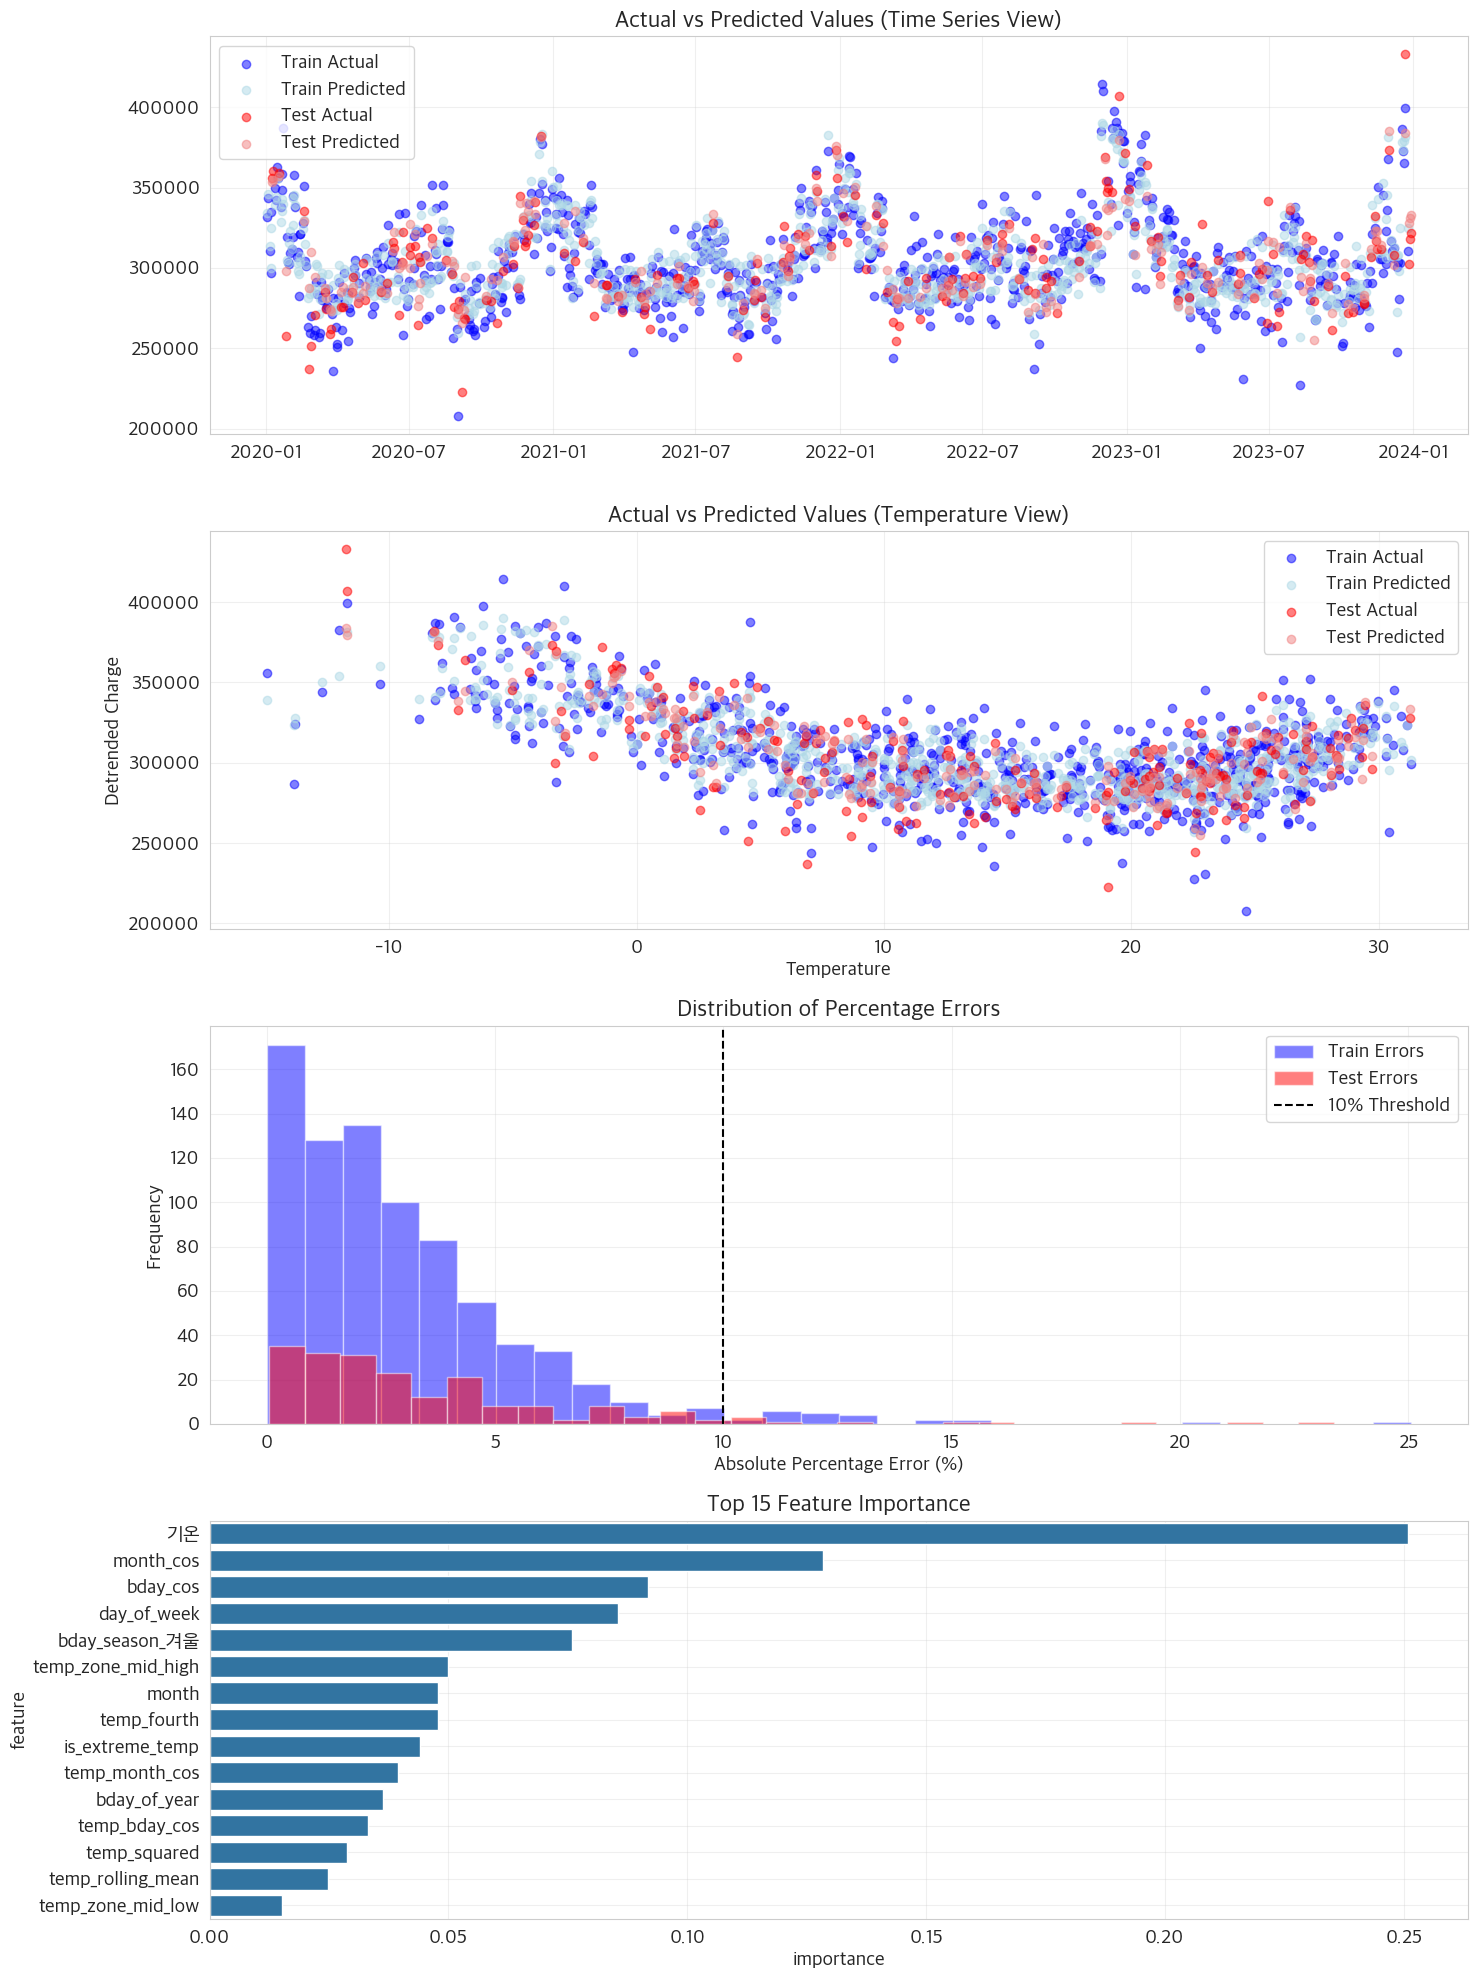


=== Model Performance ===
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.7}

Error Metrics:
Train RMSE: 11638.25
Test RMSE: 14666.82
Train MAE: 8765.28
Test MAE: 10686.95
Train MAPE: 2.94%
Test MAPE: 3.62%
Train MSLE: 0.0016
Test MSLE: 0.0025

Goodness of Fit:
Train R²: 0.828
Test R²: 0.761

Tolerance-based Metrics:

Train Set:
Within ±5%: 83.7%
Within ±10%: 97.1%
Within ±15%: 99.4%
Within ±20%: 99.8%

Test Set:
Within ±5%: 78.1%
Within ±10%: 94.5%
Within ±15%: 98.0%
Within ±20%: 99.0%


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_log_error,
)
from xgboost import XGBRegressor
import seaborn as sns

years = [2020, 2021, 2022, 2023]
combined_df = pd.DataFrame()

# 모든 연도의 데이터를 먼저 합침
for year in years:
    df_temp = pd.read_csv(f"data/daily_temp_{year}.csv")
    df_ev = pd.read_csv(f"data/daily_ev_charge_{year}.csv")
    df = pd.merge(df_temp, df_ev, on="날짜")
    combined_df = pd.concat([combined_df, df])

combined_df["날짜"] = pd.to_datetime(combined_df["날짜"])
combined_df = combined_df.sort_values("날짜").reset_index(drop=True)
overall_trend = (
    combined_df["충전량"].rolling(window=250, center=True, min_periods=125).mean()
)
detrended_charge = combined_df["충전량"] / overall_trend * overall_trend.mean()
combined_df["detrended_charge"] = detrended_charge
combined_df["detrended_charge_ma"] = detrended_charge.rolling(
    window=5, min_periods=1
).mean()


def create_advanced_features(df):
    df = df.copy()

    # 1. 핵심 시간 특성
    df["날짜"] = pd.to_datetime(df["날짜"])
    df["month"] = df["날짜"].dt.month
    df["day_of_week"] = df["날짜"].dt.dayofweek

    # 2. 이중 계절성 특성 (연간 + 월간)
    # 2.1 영업일 기준 연간 계절성 (250일 기준)
    df["bday_of_year"] = df.groupby(df["날짜"].dt.year).cumcount() + 1
    df["bday_cos"] = np.cos(2 * np.pi * df["bday_of_year"] / 250)

    # 2.2 월별 계절성
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # 3. 온도 관련 핵심 특성
    # 3.1 비선형성 포착
    df["temp_squared"] = df["기온"] ** 2
    df["temp_fourth"] = df["기온"] ** 4

    # 3.2 극한 기온 특성
    temp_quantiles = df["기온"].quantile([0.05, 0.95])
    df["is_extreme_temp"] = (
        (df["기온"] < temp_quantiles[0.05]) | (df["기온"] > temp_quantiles[0.95])
    ).astype(int)

    # 4. 온도-계절성 상호작용
    df["temp_bday_cos"] = df["기온"] * df["bday_cos"]
    df["temp_month_cos"] = df["기온"] * df["month_cos"]

    # 5. 영업일 기준 계절 구분
    df["bday_season"] = pd.cut(
        df["bday_of_year"],
        bins=[0, 62, 125, 187, 250],
        labels=["봄", "여름", "가을", "겨울"],
        include_lowest=True,
    )

    # 6. 온도 구간 특성
    df["temp_zone"] = pd.qcut(
        df["기온"], q=4, labels=["low", "mid_low", "mid_high", "high"]
    )

    # 7. 이동평균 특성 (21 영업일 ≈ 30 달력일)
    df["temp_rolling_mean"] = df["기온"].rolling(window=21, min_periods=1).mean()

    # 범주형 변수 원핫 인코딩
    df = pd.get_dummies(df, columns=["temp_zone", "bday_season"], drop_first=True)

    # NaN 값 처리
    df = df.bfill().ffill()

    return df


def tolerance_accuracy(y_true, y_pred, tolerance_pct=10):
    """허용 오차 범위 내의 예측 비율 계산"""
    percent_errors = np.abs((y_true - y_pred) / y_true) * 100
    within_tolerance = np.sum(percent_errors <= tolerance_pct)
    return within_tolerance / len(y_true)


def train_and_evaluate_model(combined_df):
    # 1. 데이터 준비
    df = create_advanced_features(combined_df)

    # 2. 특성과 타겟 분리
    feature_columns = [
        col
        for col in df.columns
        if col
        not in [
            "날짜",
            "detrended_charge",
            "충전량",
            "charge_ma",
            "detrended_charge_ma",
        ]
    ]
    X = df[feature_columns]
    y = df["detrended_charge"]
    dates = df["날짜"]

    # 3. 학습/테스트 분할
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X, y, dates, test_size=0.2, random_state=193
    )

    # 4. 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 5. XGBoost 모델 정의 및 그리드서치
    xgb_model = XGBRegressor(random_state=93)
    param_grid = {
        "n_estimators": [150, 200],
        "max_depth": [3, 4],
        "learning_rate": [0.05, 0.1],
        "min_child_weight": [2, 3],
        "subsample": [0.6, 0.7],
        "gamma": [0.1, 0.2],
        "colsample_bytree": [0.8, 0.9],
    }

    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )

    # 6. 모델 학습
    print("모델 학습 중...")
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_

    # 7. 예측
    train_pred = best_model.predict(X_train_scaled)
    test_pred = best_model.predict(X_test_scaled)

    # 8. 평가 지표 계산
    metrics = {
        "train_rmse": np.sqrt(mean_squared_error(y_train, train_pred)),
        "test_rmse": np.sqrt(mean_squared_error(y_test, test_pred)),
        "train_r2": r2_score(y_train, train_pred),
        "test_r2": r2_score(y_test, test_pred),
        "train_mae": mean_absolute_error(y_train, train_pred),
        "test_mae": mean_absolute_error(y_test, test_pred),
        "train_mape": mean_absolute_percentage_error(y_train, train_pred) * 100,
        "test_mape": mean_absolute_percentage_error(y_test, test_pred) * 100,
        "train_msle": mean_squared_log_error(y_train, train_pred),
        "test_msle": mean_squared_log_error(y_test, test_pred),
    }

    # 9. 허용 오차 기반 지표
    for tol in [5, 10, 15, 20]:
        metrics[f"train_within_{tol}pct"] = (
            tolerance_accuracy(y_train, train_pred, tol) * 100
        )
        metrics[f"test_within_{tol}pct"] = (
            tolerance_accuracy(y_test, test_pred, tol) * 100
        )

    # 10. 결과 시각화
    plt.figure(figsize=(15, 20))

    # 10.1 시계열 시각화
    plt.subplot(4, 1, 1)
    plt.scatter(dates_train, y_train, alpha=0.5, label="Train Actual", color="blue")
    plt.scatter(
        dates_train, train_pred, alpha=0.5, label="Train Predicted", color="lightblue"
    )
    plt.scatter(dates_test, y_test, alpha=0.5, label="Test Actual", color="red")
    plt.scatter(
        dates_test, test_pred, alpha=0.5, label="Test Predicted", color="lightcoral"
    )
    plt.title("Actual vs Predicted Values (Time Series View)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 10.2 온도 기반 산점도
    plt.subplot(4, 1, 2)
    plt.scatter(X_train["기온"], y_train, alpha=0.5, label="Train Actual", color="blue")
    plt.scatter(
        X_train["기온"],
        train_pred,
        alpha=0.5,
        label="Train Predicted",
        color="lightblue",
    )
    plt.scatter(X_test["기온"], y_test, alpha=0.5, label="Test Actual", color="red")
    plt.scatter(
        X_test["기온"], test_pred, alpha=0.5, label="Test Predicted", color="lightcoral"
    )
    plt.xlabel("Temperature")
    plt.ylabel("Detrended Charge")
    plt.title("Actual vs Predicted Values (Temperature View)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 10.3 오차 분포
    plt.subplot(4, 1, 3)
    train_errors = np.abs((y_train - train_pred) / y_train) * 100
    test_errors = np.abs((y_test - test_pred) / y_test) * 100
    plt.hist(train_errors, bins=30, alpha=0.5, label="Train Errors", color="blue")
    plt.hist(test_errors, bins=30, alpha=0.5, label="Test Errors", color="red")
    plt.axvline(10, color="black", linestyle="--", label="10% Threshold")
    plt.xlabel("Absolute Percentage Error (%)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Percentage Errors")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 10.4 특성 중요도
    importance_df = pd.DataFrame(
        {"feature": X_train.columns, "importance": best_model.feature_importances_}
    ).sort_values("importance", ascending=False)

    plt.subplot(4, 1, 4)
    sns.barplot(data=importance_df.head(15), x="importance", y="feature")
    plt.title("Top 15 Feature Importance")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 11. 결과 출력
    print("\n=== Model Performance ===")
    print(f"Best Parameters: {grid_search.best_params_}")

    print("\nError Metrics:")
    print(f"Train RMSE: {metrics['train_rmse']:.2f}")
    print(f"Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Train MAE: {metrics['train_mae']:.2f}")
    print(f"Test MAE: {metrics['test_mae']:.2f}")
    print(f"Train MAPE: {metrics['train_mape']:.2f}%")
    print(f"Test MAPE: {metrics['test_mape']:.2f}%")
    print(f"Train MSLE: {metrics['train_msle']:.4f}")
    print(f"Test MSLE: {metrics['test_msle']:.4f}")

    print("\nGoodness of Fit:")
    print(f"Train R²: {metrics['train_r2']:.3f}")
    print(f"Test R²: {metrics['test_r2']:.3f}")

    print("\nTolerance-based Metrics:")
    print("\nTrain Set:")
    for tol in [5, 10, 15, 20]:
        print(f"Within ±{tol}%: {metrics[f'train_within_{tol}pct']:.1f}%")
    print("\nTest Set:")
    for tol in [5, 10, 15, 20]:
        print(f"Within ±{tol}%: {metrics[f'test_within_{tol}pct']:.1f}%")

    return best_model, scaler, metrics


# 실행
best_model, scaler, metrics = train_and_evaluate_model(combined_df)